In [7]:
import pandas as pd

# 1. Load the dataset
# Make sure 'akuna_data.csv' is in the same folder as this notebook

df= pd.read_csv("data/akuna_data.csv",)

print(f"Initial dataset shape: {df.shape}")
df.head()

Initial dataset shape: (117, 110)


,Submission ID,Respondent ID,Submitted at,In che lingua preferisci svolgere questo sondaggio? - \nIn which language would you prefer to take the survey?,Hai mai acquistato delle scarpe da calcio?,Qual è il tuo genere?,Che lavoro fai?,Da dove provieni?,Quanti anni hai?,"Di solito, in che ruolo giochi?",...,Performance (10),Quality (5),At what price would the product seem so low in quality that you would no longer consider buying it?\n,At what price would the product start to seem like a very good deal?\n,At what price would you start to consider the product too expensive?\n,At what price would the product be so expensive that you would no longer consider buying it?\n,At what price would the product seem so low in quality that you would no longer consider buying it?\n (2),At what price would the product start to seem like a very good deal?\n (2),At what price would you start to consider the product too expensive?\n (2),At what price would the product be so expensive that you would no longer consider buying it?\n (2)
0,rjXaBGX,PdANzXP,2026-02-05 14:27:37,Italiano,No,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,jaK66l4,yPlbJQp,2026-02-05 14:29:56,English,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,35.0,50.0,80.0,100.0,35.0,50.0,80.0,100.0
2,44ZJJyr,WOA6zzN,2026-02-05 14:31:37,Italiano,Sì,Maschio,Dipendente,Puglia,30.0,Centrocampista,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,ZjxEEMz,zxKAYZq,2026-02-05 14:32:21,English,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,15.0,25.0,75.0,100.0,15.0,25.0,80.0,120.0
4,GxM998j,yPlbYE0,2026-02-05 14:32:37,Italiano,No,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
# --- PHASE 1: MERGE ENGLISH -> ITALIAN ---

# Identify where the English section starts
english_start_phrase = "Have you ever bought a pair of football boots?"
split_index = -1
for i, col in enumerate(df.columns):
    if english_start_phrase in col:
        split_index = i
        break

if split_index == -1:
    raise ValueError("English section not found in CSV columns.")

# Define Italian and English column ranges
# (Adjust index 4 if your metadata columns differ)
italian_cols = df.columns[4:split_index]
english_cols = df.columns[split_index:]

# Create a working copy
df_compact = df.copy()

# Fill Italian NaNs with English responses
for col_it, col_en in zip(italian_cols, english_cols):
    df_compact[col_it] = df_compact[col_it].fillna(df_compact[col_en])

# Drop the now redundant English columns
df_compact = df_compact.drop(columns=english_cols)

print(f"Total columns after merging: {len(df_compact.columns)}")

Total columns after merging: 57


In [9]:
# --- PHASE 2: APPLY FILTERS ---

# Filter 1: Remove respondents who have never bought football boots
col_shoes = "Hai mai acquistato delle scarpe da calcio?"
df_compact = df_compact[df_compact[col_shoes].astype(str).str.strip() != 'No']

# Filter 2: Remove respondents who have never heard of Akuna
col_akuna = 'Hai mai sentito parlare del brand "Akuna - Cinquestelle 1911"?'
df_compact = df_compact[df_compact[col_akuna].astype(str).str.strip() != 'No']

print(f"Rows remaining after filtering: {len(df_compact)}")

Rows remaining after filtering: 14


In [10]:
# --- PHASE 3: PREPARE POSITIONING DATA ---

# Locate the brand awareness column to set the starting point
try:
    start_idx = df_compact.columns.get_loc(col_akuna)
except KeyError:
    for i, c in enumerate(df_compact.columns):
        if "Hai mai sentito parlare del brand" in c:
            start_idx = i
            break

# Locate the end of the section (where pricing questions begin)
end_idx = -1
for i, col in enumerate(df_compact.columns):
    if "A che prezzo" in col:
        end_idx = i
        break

# Extract the positioning subset
if end_idx != -1:
    df_pos = df_compact.iloc[:, start_idx:end_idx].copy()
else:
    df_pos = df_compact.iloc[:, start_idx:].copy()

# Define labels for renaming
brands = ["adidas", "akuna", "diadora", "mizuno", "pantofola_doro"]
attributes = ["craftsmanship", "durability", "popularity", "performance", "quality"]

new_pos_cols = ["know_akuna"]

# Generate standardized English column names
for brand in brands:
    for attr in attributes:
        new_pos_cols.append(f"{attr}_{brand}")

# Apply names if the count matches
if len(new_pos_cols) == len(df_pos.columns):
    df_pos.columns = new_pos_cols
    print("Columns renamed successfully.")
else:
    print(f"Error: Expected {len(new_pos_cols)} columns, found {len(df_pos.columns)}")

Columns renamed successfully.


In [11]:
# --- PHASE 4: TRANSFORMATION FOR ANALYSIS ---

long_dfs = []

for brand in brands:
    # Select columns belonging to the current brand
    cols_to_keep = [f"{attr}_{brand}" for attr in attributes]
    
    # Create temp dataframe and strip the brand name from columns
    temp_df = df_pos[cols_to_keep].copy()
    temp_df.columns = attributes
    
    # Tag with brand name
    temp_df['brand'] = brand
    long_dfs.append(temp_df)

# Combine all into one master ratings dataframe
akuna_ratings = pd.concat(long_dfs, ignore_index=True)
akuna_ratings.head()

,craftsmanship,durability,popularity,performance,quality,brand
0,1.0,2.0,5.0,3.0,2.0,adidas
1,2.0,4.0,4.0,4.0,4.0,adidas
2,2.0,3.0,5.0,4.0,3.0,adidas
3,5.0,4.0,2.0,4.0,4.0,adidas
4,3.0,4.0,5.0,3.0,4.0,adidas


In [12]:
# --- PHASE 5: CALCULATE MEANS ---

# Group by brand and calculate the average for each attribute
akuna_perceptual = akuna_ratings.groupby("brand").mean(numeric_only=True)

print("Final Perceptual Map Coordinates (Brand Means):")
akuna_perceptual

Final Perceptual Map Coordinates (Brand Means):


,craftsmanship,durability,popularity,performance,quality
brand,,,,,
adidas,2.000000,3.428571,4.571429,3.714286,3.428571
akuna,4.857143,4.071429,2.142857,3.642857,4.357143
diadora,2.857143,3.214286,2.714286,3.142857,3.000000
mizuno,2.928571,3.357143,2.428571,3.214286,3.357143
pantofola_doro,4.357143,3.642857,2.714286,3.500000,3.857143


In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# We assume 'akuna_perceptual' was created in the previous steps.
# If not, ensure you run the previous block that calculates the means first.
# (Note: Python is case-sensitive, ensure the variable name matches your previous code)
data = akuna_perceptual 

print("Data loaded for PCA analysis.")

Data loaded for PCA analysis.


In [14]:
# 1. Data Standardization
# (Equivalent to normalize=True in some R packages)
scaler = StandardScaler()
data_std = scaler.fit_transform(data)

# 2. Execute PCA
pca = PCA(n_components=2)
results = pca.fit_transform(data_std)

# Create a DataFrame with Brand Coordinates (Scores)
coord = pd.DataFrame(results, columns=['PC1', 'PC2'], index=data.index)

# Create a DataFrame with Attribute Vectors (Loadings)
loadings = pd.DataFrame(pca.components_.T, columns=['PC1', 'PC2'], index=data.columns)

print("PCA analysis complete.")
print(f"Explained Variance Ratio: {pca.explained_variance_ratio_}")

PCA analysis complete.
Explained Variance Ratio: [0.65865357 0.32691972]


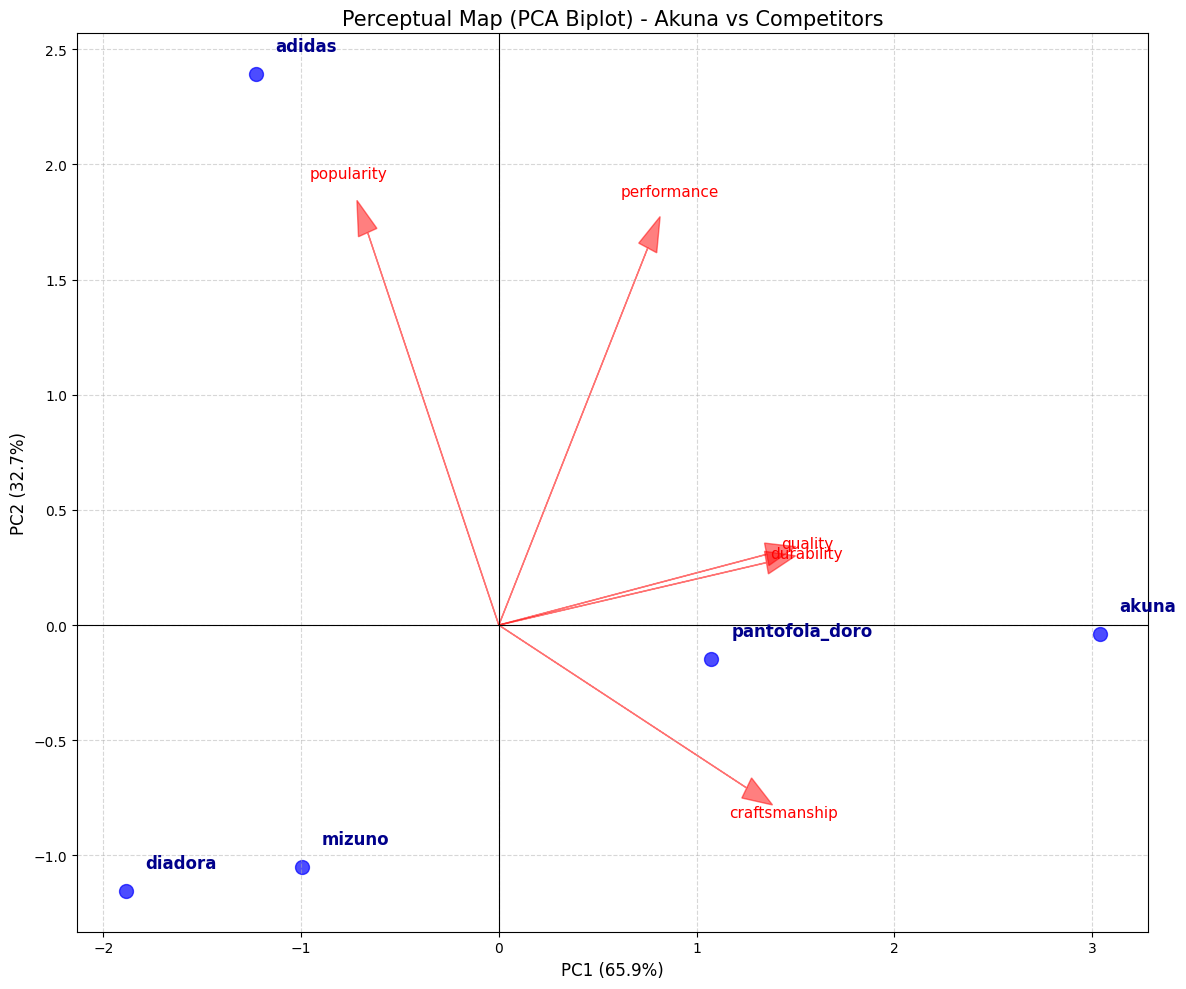

In [15]:
# 3. Create the Biplot
plt.figure(figsize=(12, 10))
ax = plt.gca()

# --- Draw BRANDS (Blue Points) ---
# Scatter plot of coordinates
ax.scatter(coord['PC1'], coord['PC2'], c='blue', s=100, alpha=0.7, label='Brands')

# Add labels for the brands
for i, txt in enumerate(coord.index):
    # Offset the text slightly so it doesn't overlap the dot
    ax.text(coord.iloc[i, 0] + 0.1, coord.iloc[i, 1] + 0.1, txt, 
            fontsize=12, weight='bold', color='darkblue')

# --- Draw ATTRIBUTES (Red Arrows) ---
# Scale arrows to fit the dimension of the brand plot
# This replaces 'scale_factor' from your original logic
scale_factor = 2.5  # Adjust this value if arrows are too short/long

for i, txt in enumerate(loadings.index):
    # Arrow coordinates
    x_arrow = loadings.iloc[i, 0] * scale_factor
    y_arrow = loadings.iloc[i, 1] * scale_factor

    # Draw the arrow
    ax.arrow(0, 0, x_arrow, y_arrow, color='red', alpha=0.5, head_width=0.1)

    # Add the attribute label
    ax.text(x_arrow * 1.15, y_arrow * 1.15, txt, 
            color='red', ha='center', va='center', fontsize=11)

# 4. Chart Formatting
xlabel = f"PC1 ({pca.explained_variance_ratio_[0]*100:.1f}%)"
ylabel = f"PC2 ({pca.explained_variance_ratio_[1]*100:.1f}%)"

ax.set_xlabel(xlabel, fontsize=12)
ax.set_ylabel(ylabel, fontsize=12)
ax.set_title('Perceptual Map (PCA Biplot) - Akuna vs Competitors', fontsize=15)
ax.grid(True, linestyle='--', alpha=0.5)

# Axis lines passing through the origin (0,0)
ax.axhline(0, color='black', linewidth=0.8)
ax.axvline(0, color='black', linewidth=0.8)

# Show the plot
plt.tight_layout()
plt.show()

# (Optional) Save the chart
# plt.savefig('akuna_perceptual_map.png')

The perceptual map shows that the market is structured along two main dimensions: PC1 (65.9%) represents premium craftsmanship, quality, and durability, while PC2 (32.7%) captures popularity and performance perception. Together, they explain almost all the variance, making the positioning highly reliable. Akuna is positioned strongly on the right side of the map, meaning it is perceived as very high in craftsmanship and quality, but it scores low on popularity. This indicates that Akuna is seen as a premium, artisanal brand with strong product value but limited brand awareness. In contrast, Adidas occupies the upper area of the map, reflecting high popularity and strong performance perception, but lower craftsmanship compared to Akuna. Pantofola d’Oro is also positioned toward the premium side but less extreme than Akuna, while Mizuno and Diadora appear more mid-market and less differentiated. Strategically, Akuna’s competitive advantage lies in its premium craftsmanship positioning rather than mass-market recognition. The main opportunity is to increase brand awareness without compromising its high-end identity. Notably, there is a “white space” in the market: no brand combines very high craftsmanship with very high popularity. If Akuna manages to strengthen awareness while preserving its premium perception, it could occupy this attractive and currently underserved position.